In [1]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
# ms-python.python added
import os
try:
	os.chdir(os.path.join(os.getcwd(), '..'))
	print(os.getcwd())
except:
	pass


/home/mutaz/ilab1


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.contrib.distributions import Bernoulli
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.model_selection import KFold 
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.patches as mpatches
import sys
from sklearn.model_selection import StratifiedKFold



/home/mutaz/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mutaz/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mutaz/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/mutaz/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: Futu

In [3]:
 

def run_train(session, train_x, train_y):
    print ("\nStart training")
    batch_size=16
    for epoch in range(5000):
        total_batch = int(train_x.shape[0] / batch_size)
    for i in range(total_batch):
        batch_x = train_x[i*batch_size:(i+1)*batch_size]
        batch_y = train_y[i*batch_size:(i+1)*batch_size]
        mse, c = session.run([model_mse,train_step], feed_dict={model_X: batch_x, model_y: batch_y})
        if i % 100 == 0:
            print("Iteration {}. Mean squared error: {:.4f}.".format(i, mse))


def cross_validate(split_size,session,train_x_all,train_y_all):
    retults=[]
    total_folds= int(train_x_all.shape[0]/split_size)
    
    for i in range(split_size):
        train_x = train_x_all[i*total_folds:(i+1)*total_folds]
        train_y = train_y_all[i*total_folds:(i+1)*total_folds]
        run_train(session, train_x, train_y)






class VariationalDense:
    """Variational Dense Layer Class"""
    def __init__(self, n_in, n_out, model_prob, model_lam):
        self.model_prob = model_prob
        self.model_lam = model_lam
        self.model_bern = Bernoulli(probs=self.model_prob, dtype=tf.float32)
        self.model_M = tf.Variable(tf.truncated_normal([n_in, n_out], stddev=0.001))
        self.model_m = tf.Variable(tf.zeros([n_out]))
        self.model_W = tf.matmul(
            tf.diag(self.model_bern.sample((n_in, ))), self.model_M
        )

    def __call__(self, X, activation=tf.identity):
        output = activation(tf.matmul(X, self.model_W) + self.model_m)
        if self.model_M.shape[1] == 1:
            output = tf.squeeze(output)
        return output

    @property
    def regularization(self):
        return self.model_lam * (
            self.model_prob * tf.reduce_sum(tf.square(self.model_M)) +
            tf.reduce_sum(tf.square(self.model_m))
        )


In [4]:

count=999
path = './data/WR2/LASSO_BR2_BEST_extended/'

train_df = pd.read_csv(str(path)+"kmeans_randomized_trainingset_0_unindexed.csv",header=None)
test_df = pd.read_csv(str(path)+"kmeans_randomized_testset_0_unindexed.csv",header=None)
test_train_df = pd.read_csv(str(path)+"COMPLETE_DL_SET.csv",header=None)


In [5]:
# we need to split the test_df into test and holdout 
# test df has 43 points
# split 60/40
# -> hold out will be 17 points, and th rest for cross val


In [6]:
numColumns = train_df.shape[1]


X_training_test = test_train_df.iloc[:,1:numColumns]
#y_training_test = test_train_df.iloc[:,numColumns-1]

X = train_df.iloc[:,0:numColumns-1] # all the features
y = train_df.iloc[:,numColumns-1] # the y - the label

X_pred = test_df.iloc[:,0:numColumns-1]
y_pred = test_df.iloc[:,numColumns-1]


In [7]:
X.describe().to_csv(str(path)+'X_train_stat.csv')
X_pred.describe().to_csv(str(path)+'X_test_stat.csv')
X_training_test.describe().to_csv(str(path)+'LARGE_DL_SET_stat.csv')
######################



In [8]:
scaler = preprocessing.StandardScaler().fit(X_training_test)



In [9]:
X = pd.DataFrame(scaler.transform(X), index=X.index.values, columns=X.columns.values)
X_pred = pd.DataFrame(scaler.transform(X_pred), index=X_pred.index.values, columns=X_pred.columns.values)
X_training_test = pd.DataFrame(scaler.transform(X_training_test), index=X_training_test.index.values, columns=X_training_test.columns.values)


In [10]:

n_samples =  X.shape[0]



In [11]:

# Create the TensorFlow model.



n_feats = X.shape[1]
n_hidden = 128


model_prob = 0.9
model_lam = 1e-3
model_X = tf.placeholder(tf.float32, [None, n_feats])
model_y = tf.placeholder(tf.float32, [None])
model_L_1 = VariationalDense(n_feats, n_hidden, model_prob, model_lam)
#model_L_1b = VariationalDense(n_hidden, int(n_hidden/2), model_prob, model_lam)
model_L_2 = VariationalDense(int(n_hidden), int(n_hidden*2), model_prob, model_lam)
model_L_3 = VariationalDense(int(n_hidden*2), int(n_hidden/8), model_prob, model_lam)
model_L_4 = VariationalDense(int(n_hidden/8), 1, model_prob, model_lam)
#model_L_5 = VariationalDense(32, 1, model_prob, model_lam)
model_out_1 = model_L_1(model_X, tf.nn.relu)
#model_out_1b = model_L_1b(model_out_1, tf.nn.relu)
model_out_2 = model_L_2(model_out_1, tf.nn.relu)
model_out_3= model_L_3(model_out_2,tf.nn.relu)
#model_out_4= model_L_4(model_out_3,tf.nn.relu)
model_pred = model_L_4(model_out_3)
model_sse = tf.reduce_sum(tf.square(model_y - model_pred))
#model_sse = -tf.reduce_sum(model_y * tf.log(model_pred))     #cross entropy
model_mse = model_sse / n_samples
model_loss = (
        # Negative log-likelihood.
        model_sse+ 
        # Regularization.
        model_L_1.regularization +
#        model_L_1b.regularization +
        model_L_2.regularization +
        model_L_3.regularization
        ) / n_samples

 

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


In [12]:
train_step = tf.train.AdamOptimizer(1e-3).minimize(model_loss)
saver = tf.train.Saver() 
bmse=np.inf
br2=0


In [16]:
train_mse = []
val_mse = []
val_r2 = []
iteration = []

In [17]:
with tf.Session() as sess:

    sess.run(tf.global_variables_initializer())
    #cross_validate(split_size=10,session=sess,train_x_all=X,train_y_all=y)
    for i in range(30001):
        sess.run(train_step, {model_X: X, model_y: y})
        if i % 100 == 0:
            mse = sess.run(model_mse, {model_X: X, model_y: y})
            

            # Sample from the posterior val set
            n_post = 400
            Y_post = np.zeros((n_post, X_pred.shape[0]))
            for j in range(n_post):
                Y_post[j] = sess.run(model_pred, {model_X: X_pred})
            Y_post_mean = Y_post.mean(axis=0)
            vmse=mean_squared_error(y_pred, Y_post_mean)
            r2=r2_score(y_pred, Y_post_mean)

            print("Iteration {}. Train MSE: {:.6f}. Val MSE: {:.6f} Val R2:{:.6f}".format(i, mse,vmse,r2))
            train_mse.append(mse)
            val_mse.append(vmse)
            val_r2.append(r2)
            iteration.append(i)
            #if vmse<bmse:
            if br2<r2:
                # Sample from the posterior test set
                bmse=vmse
                br2=r2      
                Y_post_val=Y_post.copy()  
                save_path = saver.save(sess, str(path)+'model'+str(count))
                print("best Model saved in path: %s" % save_path) 



Iteration 0. Train MSE: 1954.963135. Val MSE: 2705.532685 Val R2:-2.190156
Iteration 100. Train MSE: 523.994385. Val MSE: 721.436265 Val R2:0.149338
best Model saved in path: ./data/WR2/LASSO_BR2_BEST_extended/model999
Iteration 200. Train MSE: 470.251892. Val MSE: 634.341676 Val R2:0.252033
best Model saved in path: ./data/WR2/LASSO_BR2_BEST_extended/model999
Iteration 300. Train MSE: 507.272736. Val MSE: 626.534623 Val R2:0.261239
best Model saved in path: ./data/WR2/LASSO_BR2_BEST_extended/model999
Iteration 400. Train MSE: 548.191040. Val MSE: 704.651078 Val R2:0.169130
Iteration 500. Train MSE: 446.040283. Val MSE: 661.425359 Val R2:0.220098
Iteration 600. Train MSE: 568.069031. Val MSE: 674.153504 Val R2:0.205090
Iteration 700. Train MSE: 432.132874. Val MSE: 666.122522 Val R2:0.214560
Iteration 800. Train MSE: 488.670715. Val MSE: 692.298962 Val R2:0.183694
Iteration 900. Train MSE: 554.919128. Val MSE: 733.740695 Val R2:0.134830
Iteration 1000. Train MSE: 421.316162. Val MSE: 6

In [18]:
training_iterations_df = pd.DataFrame({'train_mse': train_mse,
                                      'val_mse': val_mse, 
                                      'val_r2': val_r2}, 
                                     index=iteration)

In [19]:
training_iterations_df.head()

,train_mse,val_mse,val_r2
0,1954.963135,2705.532685,-2.190156
100,523.994385,721.436265,0.149338
200,470.251892,634.341676,0.252033
300,507.272736,626.534623,0.261239
400,548.191040,704.651078,0.169130


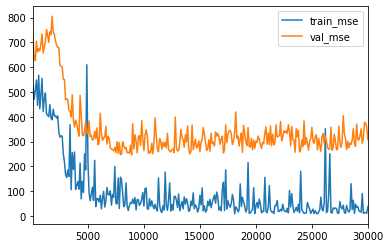

In [23]:
training_iterations_df[['train_mse', 'val_mse']].iloc[1:].plot()

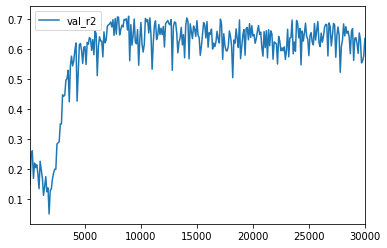

In [25]:
training_iterations_df[['val_r2']].iloc[1:].plot()

In [ ]:
with tf.Session() as sess:  
    graph = tf.get_default_graph()
    saver = tf.train.import_meta_graph(str(path)+'model'+str(count)+'.meta')
    saver.restore(sess,tf.train.latest_checkpoint(str(path)))    
    pmodel = graph.get_tensor_by_name(model_pred.name) 

    Y_post_train = np.zeros((n_post, X.shape[0]))
    for j in range(n_post):
        Y_post_train[j] = sess.run(pmodel, {model_X: X}) 



In [ ]:

########  Train/Test phase #################################################
    
    
########  Test set #################################################

#    
#
#
Y_post_mean = Y_post_val.mean(axis=0)
Y_post_std=   Y_post_val.std(axis=0)
#print(Y_post_val.mean(axis=0), Y_post_val.std(axis=0))


print('R2-VAL:',r2_score(y_pred, Y_post_mean))
print('MSE-VAL:',mean_squared_error(y_pred, Y_post_mean))
print('MAE-VAL:',mean_absolute_error(y_pred, Y_post_mean))




In [ ]:
if True:
    plt.figure(figsize=(10, 10))
    for i in range(n_post):
        plt.plot(X_pred.iloc[:, 0], Y_post_val[i], "b.", alpha=1. / 200)
    plt.plot(X_pred.iloc[:, 0], y_pred, "g.")
    plt.grid()
#    plt.xlim(-0,-0.8)
#    plt.ylim(-0,-0.8)
    plt.ylabel('C33 ($GPa$)', fontsize=24)
    plt.xlabel('Feature 1', fontsize=24)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.title("validation test")
    plt.savefig(str(path)+'C33_Feat(VAL)'+str(count), bbox_inches='tight')
    plt.show()
    
    


In [ ]:
if True:
    plt.figure(figsize=(10, 10))    
    plt.errorbar(y_pred, Y_post_mean, yerr=Y_post_std, fmt='g.')#, "r.", alpha=1. / 200)
#    plt.plot(y_pred, y_pred, "r.")
    plt.plot(y_pred,y_pred, "b-")
    plt.grid()   
    #plt.xlim(-0.1,-0.6)
    #plt.ylim(-0.1,-0.6)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.ylabel('NN-TEST ($GPa$)', fontsize=24)
    plt.xlabel('DFT ($GPa$)', fontsize=24) 
    plt.title("validation set")   
#    plt.text(-0.05, -0.08, r'MSE ='+str(round(MSE,4)))
#    plt.text(-0.05, -0.02, r'MAE ='+str(round(MAE,4)))
    plt.savefig(str(path)+'UncertaintyVAL'+str(count), bbox_inches='tight')
    plt.show()
    


In [ ]:
########  Train set  #################################################
           
    
Y_post_mean = Y_post_train.mean(axis=0)
Y_post_std=   Y_post_train.std(axis=0)
#print(Y_post_train.mean(axis=0), Y_post_train.std(axis=0))


print('R2-TRAIN:',r2_score(y, Y_post_mean))
print('MSE-TRAIN:',mean_squared_error(y, Y_post_mean))
print('MAE_TRAIN:',mean_absolute_error(y, Y_post_mean))



In [ ]:
if True:
    plt.figure(figsize=(10, 10))
    for i in range(n_post):
        plt.plot(X.iloc[:, 0], Y_post_train[i], "b.", alpha=1. / 200)
    plt.plot(X.iloc[:, 0], y, "g.")
    plt.grid()
#    plt.xlim(-0,-0.8)
#    plt.ylim(-0,-0.8)
    plt.ylabel('C33 (Train)', fontsize=24)
    plt.xlabel('Feature 1', fontsize=24)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.title("Train set")
    plt.savefig(str(path)+'C33(TRAIN)'+str(count), bbox_inches='tight')
    plt.show()


In [ ]:
if True:
    plt.figure(figsize=(10, 10))    
    plt.errorbar(y, Y_post_mean, yerr=Y_post_std, fmt='g.')#, "r.", alpha=1. / 200)
#    plt.plot(y_pred, y_pred, "r.")
    plt.plot(y, y, "b-")
    plt.grid() 
    #plt.xlim(-0.1,-0.6)
    plt.xticks(fontsize=16)
    #plt.ylim(-0.1,-0.6)
    plt.yticks(fontsize=16)
    plt.title("Train set")
    plt.ylabel('NN-TRAIN ($GPa$)', fontsize=24)
    plt.xlabel('DFT ($GPa$)', fontsize=24)
#    red_patch = mpatches.Patch(label='The red data')
#    plt.legend(handles=[red_patch])    
#    plt.text(-0.05, -0.08, r'MSE ='+str(round(MSE,4)))
#    plt.text(-0.05, -0.02, r'MAE ='+str(round(MAE,4)))
    plt.savefig(str(path)+'UncertaintyTRAIN'+str(count), bbox_inches='tight')
    plt.show()
    




